In [1]:
from dotenv import load_dotenv
import os
import pandas as pd
from pyoso import Client
from dune_client.client import DuneClient

load_dotenv()
OSO_API_KEY = os.environ['OSO_API_KEY']
DUNE_API_KEY = os.environ['DUNE_API_KEY']

oso_client = Client(api_key=OSO_API_KEY)
dune_client = DuneClient(DUNE_API_KEY)

stringify = lambda arr: "'" + "','".join(arr) + "'"

In [2]:
dune_result = dune_client.get_latest_result(4703306)
df_dune = pd.DataFrame(dune_result.result.rows, columns=dune_result.result.metadata.column_names)

HOOK_ADDRESSES = list(df_dune['hooks'].str.lower())

df_oso_hook_owners = oso_client.to_pandas(f"""
SELECT
    p.display_name,
    abp.artifact_name AS hook,    
    abp.artifact_source as chain,
    p.project_source,
    p.project_name,
    abp.artifact_id  
FROM artifacts_by_project_v1 AS abp
JOIN projects_v1 AS p ON abp.project_id = p.project_id
WHERE abp.artifact_name IN ({stringify(HOOK_ADDRESSES)})
ORDER BY 1,2,3
""")

HOOK_IDS = df_oso_hook_owners['artifact_id'].unique()

df_hook_events = oso_client.to_pandas(f"""
SELECT
    e.to_artifact_id AS project_id,
    e.time AS sample_date,
    e.time,
    e.event_type,
    e.event_source AS chain,
    e.from_artifact_id,
    e.transaction_hash,
    e.gas_fee,
    COALESCE(users.is_farcaster_user, false) AS is_farcaster_user
FROM int_superchain_events_by_project AS e
LEFT JOIN int_superchain_onchain_user_labels AS users
    ON e.from_artifact_id = users.artifact_id
WHERE
    e.time >= DATE '2024-10-01'
    AND e.to_artifact_id IN ({stringify(HOOK_IDS)})
""")

In [3]:
cols = ['hooks', 'label', 'current_tvl', 
        'pools_hooked', 'total_trades', 'total_volume']
df_dune_simple = df_dune[cols].copy()
df_dune_simple['in_oso'] = df_dune_simple['hooks'].isin(df_oso_hook_owners['hook'].unique())

In [4]:
df_dune_simple.sort_values(by='in_oso', ascending=False).head(10)

,hooks,label,current_tvl,pools_hooked,total_trades,total_volume,in_oso
0,0x0000fe59823933ac763611a69c88f91d45f81888,None,2.110072e+05,149,133785,1.372352e+08,True
1,0x51bba15255406cfe7099a42183302640ba7dafdc,Flaunch,1.837622e+06,3513,205729,9.229463e+07,True
93,0xd7651bc898e64e039e2a08827e9fd4b1bb3f68c0,None,0.000000e+00,1,2,2.092971e+01,True
386,0x2daf085ad7e6b7b1e3dc7415923e7c1cad5ee8c0,None,0.000000e+00,1,0,NaN,True
145,0xc0a9902292ca22b86220a819739f48def67180c0,None,-2.030855e-01,3,1,3.165794e-01,True
420,0xdbac778f974681e013cf8716f6b77e2f9d73e0cc,None,0.000000e+00,1,0,NaN,True
35,0x7f7d7e4a9d4da8997730997983c5ca64846868c0,None,0.000000e+00,1,60,2.045068e+04,True
6,0xc5a48b447f01e9ce3ede71e4c1c2038c38bd9000,None,4.623724e+05,11,1881,7.414314e+05,True
69,0x00001f3b9712708127b1fcad61cb892535951888,Bunni,-2.729436e+02,5,7,5.161156e+02,True
2,0x9e433f32bb5481a9ca7dff5b3af74a7ed041a888,None,-2.917966e+05,1,190452,8.793193e+07,True


In [5]:
def build_hook_metrics(df: pd.DataFrame) -> pd.DataFrame:
    
    # ------------------------------------------------------------------
    # House-keeping: datetimes & column names
    # ------------------------------------------------------------------
    df = df.copy()
    df["sample_date"] = pd.to_datetime(df["sample_date"]).dt.normalize()
    df.rename(columns={"project_id": "artifact_id"}, inplace=True)

    # ------------------------------------------------------------------
    # 1. Grouped base table: counts & gas by (month, artifact, chain, type)
    # ------------------------------------------------------------------
    grouped = (
        df.groupby(["sample_date", "artifact_id", "chain", "event_type"], as_index=False)
          .agg(count_events=("event_type", "size"),
               gas_fee=("gas_fee", "sum"))
    )

    # Helper for “metric_name / amount” frames
    def _summarize(source: pd.DataFrame, metric: str) -> pd.DataFrame:
        return (
            source.groupby(["artifact_id", "chain", "sample_date"], as_index=False)["count_events"]
                  .sum()
                  .rename(columns={"count_events": "amount"})
                  .assign(metric_name=metric)
        )

    # ------------------------------------------------------------------
    # 2. Transaction-style metrics (based on grouped counts)
    # ------------------------------------------------------------------
    transactions_monthly = _summarize(
        grouped.query("event_type == 'CONTRACT_INVOCATION'"),
        "transactions_monthly",
    )

    internal_transactions_monthly = _summarize(
        grouped.query("event_type != 'CONTRACT_INVOCATION'"),
        "internal_transactions_monthly",
    )

    contract_invocations_monthly = _summarize(
        grouped,
        "contract_invocations_monthly",
    )

    AA_EVENT_TYPES = {
        "CONTRACT_INVOCATION_VIA_USEROP",
        "CONTRACT_INVOCATION_VIA_PAYMASTER",
        "CONTRACT_INVOCATION_VIA_BUNDLER",
    }
    aa_userops_monthly = _summarize(
        grouped[grouped["event_type"].isin(AA_EVENT_TYPES)],
        "account_abstraction_userops_monthly",
    )

    # ------------------------------------------------------------------
    # 3. Address/user metrics
    # ------------------------------------------------------------------
    active_farcaster_users_monthly = (
        df[df["is_farcaster_user"]]
        .groupby(["artifact_id", "chain", "sample_date"], as_index=False)["from_artifact_id"]
        .nunique()
        .rename(columns={"from_artifact_id": "amount"})
        .assign(metric_name="active_farcaster_users_monthly")
    )

    active_addresses_monthly = (
        df.groupby(["artifact_id", "chain", "sample_date"], as_index=False)["from_artifact_id"]
          .nunique()
          .rename(columns={"from_artifact_id": "amount"})
          .assign(metric_name="active_addresses_monthly")
    )

    # ------------------------------------------------------------------
    # 4. Union-all (concat) and final ordering
    # ------------------------------------------------------------------
    metrics_df = pd.concat(
        [
            transactions_monthly,
            internal_transactions_monthly,
            contract_invocations_monthly,
            aa_userops_monthly,
            active_farcaster_users_monthly,
            active_addresses_monthly,
        ],
        ignore_index=True,
    )[["artifact_id", "chain", "sample_date", "metric_name", "amount"]]

    return metrics_df

df_metrics = (
    build_hook_metrics(df_hook_events)
    .merge(df_oso_hook_owners[['artifact_id', 'hook', 'display_name']], on='artifact_id')
)

In [6]:
df_metrics.head()

,artifact_id,chain,sample_date,metric_name,amount,hook,display_name
0,Pa83bwCBi9vdzOj7Ja0XLHbmzw4lLcfoosxr2WH5SDE=,UNICHAIN,2025-04-02,transactions_monthly,2,0x7f7d7e4a9d4da8997730997983c5ca64846868c0,Unimon
1,Pa83bwCBi9vdzOj7Ja0XLHbmzw4lLcfoosxr2WH5SDE=,UNICHAIN,2025-04-05,transactions_monthly,2,0x7f7d7e4a9d4da8997730997983c5ca64846868c0,Unimon
2,Pa83bwCBi9vdzOj7Ja0XLHbmzw4lLcfoosxr2WH5SDE=,UNICHAIN,2025-04-11,transactions_monthly,1,0x7f7d7e4a9d4da8997730997983c5ca64846868c0,Unimon
3,Pa83bwCBi9vdzOj7Ja0XLHbmzw4lLcfoosxr2WH5SDE=,UNICHAIN,2025-04-12,transactions_monthly,1,0x7f7d7e4a9d4da8997730997983c5ca64846868c0,Unimon
4,Pa83bwCBi9vdzOj7Ja0XLHbmzw4lLcfoosxr2WH5SDE=,UNICHAIN,2025-04-14,transactions_monthly,1,0x7f7d7e4a9d4da8997730997983c5ca64846868c0,Unimon


In [11]:
df_metrics['metric_name'].value_counts()

metric_name
contract_invocations_monthly           364
active_addresses_monthly               364
internal_transactions_monthly          363
active_farcaster_users_monthly         341
transactions_monthly                    99
account_abstraction_userops_monthly      2
Name: count, dtype: int64

<Axes: xlabel='sample_date'>

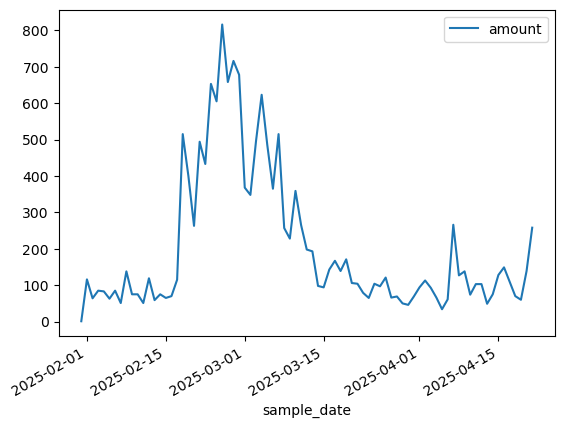

In [13]:
(
    df_metrics
    .query("hook == '0x0010d0d5db05933fa0d9f7038d365e1541a41888' and metric_name == 'contract_invocations_monthly'")
).plot(
    x='sample_date',
    y='amount'
)